In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as st
import warnings
import urllib.request

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from datetime import date, datetime, timedelta

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")

os.environ['PROJ_LIB'] = '/home/YOUR_USER/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap


In [2]:
pd.options.display.max_rows = 100        #Increases the number of rows displayed without a break in the middle.
pd.options.display.max_columns = 100     #Increases the number of columns displayed without a break in the middle.
pd.set_option('max_colwidth',100)        #Increases the width of the columns to display 100 characters at the same time.

# Data Source

538 periodically and generously updates the polls they use on Github for their analysis of national elections. You can find the link here:
https://github.com/fivethirtyeight/data/tree/master/polls



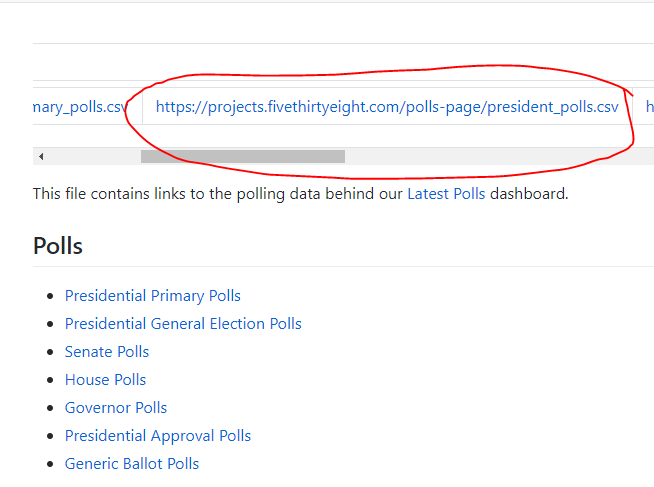

# Here are functions to allow you to read, save, plot, and analyze the polling data

In [3]:
def read_poll_data():
    
    """
    Obtains the raw poll data 538 updates hourly. It makes sure that the most recent polling data reported by 538 is read
    and saved as a pkl file. If the file already exists then it reads the data from the file.  
    
    Returns:
    df:  Returns a dataframe of the poll data in raw format. 
    
    """
    
    # 538's polling data is updated on Github hourly, so this checks to see if this poll was published this hour. 
    now = pd.to_datetime('now')
    root = '-{}-{}-{}-{}hours'.format(now.year,now.month,now.day,now.hour)
    
    if os.path.exists('./presidential_polls{}.pkl'.format(str(root))):
        df = pd.read_pickle('./presidential_polls{}.pkl'.format(str(root)))

    else:
        presidential_polls_url = "https://projects.fivethirtyeight.com/polls-page/president_polls.csv"
        df = pd.read_csv(presidential_polls_url)  # read presidential poll data
        df.state = df.state.fillna("National")    # fill na values for the state to indicate National polls
        df.to_pickle('./presidential_polls{}.pkl'.format(str(root)))
        
    return df

In [4]:
def reformat_poll_data(poll_location = "National", poll_type = "lv", smoothing_distance = 22, exclude_online_only_polls = True, polling_bias = '', bias_amount = 0):

    """
    This reformats the poll data to select by state, select the type of poll, if it's a 'lv' likely voter, 'rv' registered voter
    or 'both' both likely and registered voter polls. This also slects the size of the smoothign window to use, and it's defaulted
    to exclude polls conducted only online. 
    
    Params:
    
    poll_location:  Defaults to 'National'
    
                    This is the slice of data that is either at the national level or state level. The allowed selections are 
                    the following:
                    
                    'Iowa', 'Pennsylvania', 'Florida', 'National', 'Nebraska CD-2', 'Montana', 'Maine', 'Maine CD-2', 
                    'Maine CD-1', 'Arizona', 'North Carolina', 'Texas', 'Georgia', 'Illinois', 'Michigan', 'Minnesota', 
                    'New Jersey', 'New York', 'Ohio', 'Wisconsin', 'Colorado', 'California', 'Virginia', 'Alabama', 'Nevada',
                    'Kansas', 'South Carolina', 'Mississippi', 'Indiana', 'Connecticut', 'Kentucky', 'Louisiana', 'Maryland',
                    'Missouri', 'Oregon', 'Tennessee', 'Washington', 'Wyoming', 'West Virginia', 'Vermont', 'Utah', 
                    'South Dakota', 'Rhode Island', 'Oklahoma', 'New Mexico', 'New Hampshire', 'Nebraska', 'North Dakota', 
                    'Massachusetts', 'Idaho', 'Hawaii', 'Delaware', 'District of Columbia', 'Arkansas', 'Alaska', 
                    'Nebraska CD-1'
    
    poll_type:      Defaults to 'lv'
    
                    'lv'   - Likely Voter
                    'rv'   - Registered Voter
                    'both' - Both likely and registered voters
    
    smoothing_distance: Defaults to 22
                
                    This is the smoothing distance that the smoothing window will pass to. If the total available distance in the 
                    data is less than 22, then the window will be the distance of the available data. 

    exclude_online_only_polls: defaults to True
                    
                    True - Will exclude all online only polls
                    False - Will include online polls as well
                    
                    
    polling_bias:  Defaults to ''
                    shy_trump: Adds the bias amount to Trump's poll results
                    shy_biden: Adds the bias amount to Biden's poll results
                    trump_only: Subtracts the bias amount from Trump's poll results
                    biden_only: Subtracts the bias amount from Biden's poll results
                    trump: Subtracts half the bias amount from Trump's poll results and adds half to Biden's poll results
                    biden:  Subtracts half the bias amount from Biden's poll results and adds half to Trump's poll results
    
    bias_amount: Defaults to 0.  This is the bias amount to apply to the poll results.   
    
    Returns: 
    
    df:             Pandas Dataframe of the reformatted polling data with the selected slices of data. 
    
    """
    
    df = read_poll_data()
    
    if poll_type == 'both':
        df = df.loc[((df.population=='lv')|(df.population=='rv'))&
                    (df.state==poll_location)]  # select both lv for likely votetr or rv for registered voter
    
    else:
        df = df.loc[(df.population==poll_type)&
                    (df.state==poll_location)]  # select only lv for likely votetr or rv for registered voter
    
    if exclude_online_only_polls:
        
        df = df.loc[df.methodology != "Online"]
        
        #Use this code if you would like to exclude any form of online poll
        #df = df[~df.methodology.str.contains("Online") == True]
        
    index = [df.question_id, df.end_date, df.sample_size]
    df = pd.crosstab(index, df.candidate_name, df.pct, aggfunc = "sum", colnames = ['index'])[["Joseph R. Biden Jr.", "Donald Trump"]].dropna()
    df = df.rename(columns = {"Joseph R. Biden Jr.":"biden","Donald Trump":"trump"})
    df = df.reset_index()
    df.end_date = pd.to_datetime(df.end_date)
       
    if polling_bias.lower() == 'shy_trump':
        
        df['trump'] = df['trump'] + bias_amount
        
    elif polling_bias.lower() == 'shy_biden':
        
        df['biden'] = df['biden'] + bias_amount
       
    elif polling_bias.lower() == 'trump_only':
        
        df['trump'] = df['trump'] - bias_amount
        
    elif polling_bias.lower() == 'biden_only':
        
        df['biden'] = df['biden'] - bias_amount
        
    elif polling_bias.lower() == 'trump':
        
        df['trump'] = df['trump'] - bias_amount/2
        df['biden'] = df['biden'] + bias_amount/2
        
    elif polling_bias.lower() == 'biden':
        
        df['biden'] = df['biden'] - bias_amount/2
        df['trump'] = df['trump'] + bias_amount/2
        
    else: 
        pass
    
    df["other"] = abs(df["biden"]-df["trump"])

    # use a lowess smoother to smooth the results and calculate the residual errors
    smoothed_df =  pd.DataFrame(df['end_date'].copy())
    
    for col in ["biden","trump","other"]:

        smooth_col_name = col+'_smooth'
        smoothed_df[smooth_col_name] = smooth(df[col], smoothing_distance)
    
    # consolidate smoothing around the dates to ensure same smoothed values on the same day.
    smoothed_df = smoothed_df.groupby(by = "end_date").mean()
    smoothed_df = smoothed_df.reset_index()
    df = pd.merge(df,smoothed_df, how = 'left', left_on = 'end_date', right_on = 'end_date' )

    # calculate residual errors 
    for col in ["biden","trump","other"]:   
        err_col_name = col+'_residual_err'
        smooth_col_name = col+'_smooth'
        df[err_col_name] = df[col]-df[smooth_col_name]
        
    
    # calculate confidence intervals 
    for col in ["biden","trump","other"]:  
        
        # assign col names
        
        col_high = col+'_high'
        col_low =  col+'_low'
        
        # male calculations
        err_col_name = col+'_residual_err'
        smooth_col_name = col+'_smooth'
        
        x = df[err_col_name].values   # values
        m, m_low, m_high, sigma = intervals(x)
        
        df[col_low] = df[smooth_col_name]+m_low
        df[col_high] = df[smooth_col_name]+m_high
        df = df.sort_values('end_date')
        
    return (df)


In [5]:
def display_forecast(states_list, poll_type = 'both', polling_bias = 'None', bias_amount = 0, days_to_look_back = 250, smoothing_distance = 22, plot_states = True, election_map = True):
    
    """
    This displays the polling trends for each of the states and accounts for a polling error stated at the beginning. 
    
    Params:
    
    """
    
    forecast = {} #forecast dictionary

    for state in states_list:

        try:
            df = main(poll_type = poll_type, 
                      poll_location = state, 
                      days_to_subtract = days_to_look_back,
                      smoothing_distance = smoothing_distance, 
                      polling_bias = polling_bias,
                      bias_amount = bias_amount,
                      plot_data = plot_states)
            
            forecast = record_results(forecast, df, state)

        except:
            print("Could not plot {}".format(state))

            pass

    forecast = pd.DataFrame(forecast)
    forecast = forecast.T
    

    forecast['winner'] = np.where((forecast.biden == forecast.trump), 'tie',
                                  np.where((forecast.biden > forecast.trump), 'biden', 'trump'))
    
    forecast = forecast.reset_index().rename(columns = {'index':'state'}).sort_values(by = 'state')
    
    if election_map:
        
        plot_election_map(forecast) 
    
    return forecast

In [6]:
def intervals(data, confidence=.9973):
    
    import scipy.stats
    
    a = 1.0 * np.array(data)
    n = len(a)
    mu, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    sigma = np.std(data)
    
    return mu, mu-h, mu+h,sigma

In [7]:
def smooth(y_series, smoothing_distance=5, smoothing_iterations = 3, fill_missing = True, allow_negative_values = False):

    import statsmodels.api as sm
    
    y_series = y_series.fillna(0) # replace all NaN values with 0
    x_series = list(np.arange(0,len(y_series),1))
    
    # set lowess_window_length
    
    if smoothing_distance >= len(x_series):
        lowess_window_length = len(x_series)
    
    else: 
        lowess_window_length = smoothing_distance
        
    window = lowess_window_length/len(x_series)
    
    
    if allow_negative_values == False:
        y_series[y_series < 0] = 0  #replace all values less than zero with 0
    
    # if the dataset has NaN values, they will be replaced with linear interpolation
    if fill_missing == True:
        y_series = y_series.replace(to_replace=0, value = None).interpolate(method='linear')
        y_series = y_series.fillna(0)
    
    #log transform the series
    y_series = np.log1p(y_series)
    
    lowess = sm.nonparametric.lowess
    smooth = lowess(y_series, x_series, frac = window, it = smoothing_iterations)
    index, yhat = np.transpose(smooth)
    
    #reverse transform the series by taking the inverse log 1p
    yhat = np.expm1(yhat)
    
    return yhat

In [8]:
def plot_polls(df, days_to_subtract, poll_location, poll_type, polling_bias = '', bias_amount = 0):
    
    df = df.sort_values('end_date')
    cutoff_date = datetime.today() - timedelta(days=days_to_subtract)
    df = df.loc[df.end_date >= cutoff_date]
    
    trump_last = round(df.trump_smooth.iloc[-1],2)
    biden_last = round(df.biden_smooth.iloc[-1],2)
    last_poll_date = df.end_date.iloc[-1]

    thousands_formatter = ticker.StrMethodFormatter('{x:,.0f}%')

    if poll_type == "rv":
        polling_title = "Registered Voter"
    elif poll_type == 'lv':
        polling_title = "Likely Voter"
    else:
        polling_title = ''

    fig = plt.figure(figsize = (15,10))
    ax1 = plt.subplot2grid((60, 4), (0, 0),  rowspan=12, colspan=4)
    ax2 = plt.subplot2grid((60, 4), (14,0), rowspan=40, colspan=4)


    # plot title
    figure_title = "{} - {} Polls - {} Day Trend".format(poll_location, polling_title, days_to_subtract)
    figure_source_text = "\nThe sample size determines the size of each circle. \nDATA SOURCE: Data published on Github by 538: (This excludes polls administered only online.)\nhttps://projects.fivethirtyeight.com/polls-page/president_polls.csv"
    ax1.text(0, 0.55, figure_title, fontsize=30, fontweight='normal')
    ax1.text(0, 0.01, figure_source_text, fontsize=14, fontweight='normal')
    ax1.axis('off')

    # plot the daily values
    ax2.scatter(df["end_date"], df["trump"], facecolors="salmon", alpha = 0.40, edgecolors="darkred", s = df.sample_size/10, linewidth = 0.55)
    ax2.scatter(df["end_date"], df["biden"], facecolors="lightblue",edgecolors="darkblue", s = df.sample_size/10, alpha = 1, linewidth = 0.55)
  
    ax2.fill_between(df["end_date"], df['biden_low'], df['biden_high'], color = 'dodgerblue', alpha = 0.10 )
    ax2.fill_between(df["end_date"], df['trump_low'], df['trump_high'], color = 'salmon', alpha = 0.10 )

    ax2.plot(df["end_date"], df["trump_smooth"], linestyle = '--', linewidth = 2, color = "red", alpha = 1, label = 'Trending Trump')
    ax2.plot(df["end_date"], df["biden_smooth"], linestyle = '--', linewidth = 2, color = "dodgerblue", alpha = 1, label = 'Trending Biden')
    
    ax2.axvline(x = df["end_date"].max(), linestyle = '--', color = 'red', label = "Latest Poll", linewidth = 1)
    ax2.axvline(x = pd.to_datetime('2020-11-3'), linestyle = '--', color = 'brown', label = 'Election Day', linewidth = 3)

    ax2.set_xlim(df["end_date"].min(), pd.to_datetime('2020-11-7'))
    ax2.set_ylim(min([df["trump"].min(),df["biden"].min()])*.90, max([df["trump"].max(),df["biden"].max()])*1.10)

    ax2.tick_params(axis='x', labelsize = 12)
    ax2.tick_params(axis='y', labelsize = 19)
    ax2.yaxis.set_major_formatter(thousands_formatter)
    ax2.legend(loc = 'best', prop={'size': 14})

    plt.show()

In [9]:
def plot_election_map(forecast):
    
    plot_df = forecast[~((forecast['state'].str.contains('CD'))|(forecast['state'].str.contains('National')))].copy()
    plot_df['color'] = np.where((plot_df.winner=='tie'),'grey',np.where((plot_df.winner == 'trump'), 'salmon', 'lightblue'))

    plot_df = plot_df[['state','color']]
    plot_df

    shapefile_url = 'https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shp'
    urllib.request.urlretrieve(shapefile_url, 'st99_d00.shp')
    shapefile_url = 'https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.shx'
    urllib.request.urlretrieve(shapefile_url, 'st99_d00.shx')
    shapefile_url = 'https://github.com/matplotlib/basemap/raw/master/examples/st99_d00.dbf'
    urllib.request.urlretrieve(shapefile_url, 'st99_d00.dbf')

    # create the map
    us_map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # state boundaries
    shp_info = us_map.readshapefile('st99_d00','states',drawbounds=True)

    # choose a color for each state based on population forecast.
    colors={}
    statenames=[]

    # create a dictionary for the state colors
    for shapedict in us_map.states_info:
        statename = shapedict['NAME']

        # skip DC and Puerto Rico.
        if statename not in ['District of Columbia','Puerto Rico']:
            colors[statename] = plot_df.color.loc[plot_df.state == statename].values[0]
        statenames.append(statename)

    # cycle through state names, color each one.

    ax = plt.gca() # get current axes instance
    ax.figure.set_size_inches(11,8)
    for nshape,seg in enumerate(us_map.states):
        
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        
            color = colors[statenames[nshape]] 
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            ax.add_patch(poly)

    plt.title('\nOutcome\n', fontsize = 21)
    plt.show()

    plt.show()

In [10]:
def main(poll_type = 'both', poll_location = 'National', days_to_subtract = 250, smoothing_distance = 22, polling_bias = '', bias_amount = 0, plot_data = True):
    
    df = reformat_poll_data(poll_location, poll_type, smoothing_distance, exclude_online_only_polls = True, polling_bias = polling_bias, bias_amount=bias_amount)
    
    if plot_data:
        plot_polls(df,days_to_subtract,poll_location,poll_type, polling_bias, bias_amount)
        
    return df

In [11]:
def record_results(forecast, df, state):
    
    biden_latest = round(df.biden_smooth.max(),5)
    trump_latest = round(df.trump_smooth.max(),5)
    forecast[state] = {'biden':biden_latest,'trump':trump_latest}
    
    return forecast

# Here is how you can read in the raw polling data to do your analysis. It excludes "online" only polls.

In [12]:
df = read_poll_data()

display(df.head(2))
display(df.tail(2))

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,fte_grade,sample_size,population,population_full,methodology,office_type,seat_number,seat_name,start_date,end_date,election_date,sponsor_candidate,internal,partisan,tracking,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
0,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,Public Policy Polling,B,871.0,v,v,IVR/Text,U.S. President,0,NaN,11/1/20,11/2/20,11/3/20,NaN,False,NaN,NaN,False,False,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content/uploads/2020/11/IowaResultsNovember2020.pdf,general,6223,Biden,13256,Joseph R. Biden Jr.,DEM,49.0
1,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,Public Policy Polling,B,871.0,v,v,IVR/Text,U.S. President,0,NaN,11/1/20,11/2/20,11/3/20,NaN,False,NaN,NaN,False,False,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content/uploads/2020/11/IowaResultsNovember2020.pdf,general,6223,Trump,13254,Donald Trump,REP,48.0


,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,fte_grade,sample_size,population,population_full,methodology,office_type,seat_number,seat_name,start_date,end_date,election_date,sponsor_candidate,internal,partisan,tracking,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
16436,92078,57025,2020,National,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,Rasmussen Reports/Pulse Opinion Research,C+,1000.0,lv,lv,IVR/Online,U.S. President,0,NaN,11/12/18,11/13/18,11/3/20,NaN,False,NaN,NaN,False,False,12/6/18 14:40,NaN,http://www.rasmussenreports.com/public_content/politics/general_politics/november_2018/michelle_...,general,6210,Obama,13253,Michelle Obama,DEM,50.0
16437,92078,57025,2020,National,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,Rasmussen Reports/Pulse Opinion Research,C+,1000.0,lv,lv,IVR/Online,U.S. President,0,NaN,11/12/18,11/13/18,11/3/20,NaN,False,NaN,NaN,False,False,12/6/18 14:40,NaN,http://www.rasmussenreports.com/public_content/politics/general_politics/november_2018/michelle_...,general,6210,Trump,13254,Donald Trump,REP,43.0


# Print a list of available states and areas

In [13]:
states_list = list(df.state.unique())
print(states_list)

['Iowa', 'Pennsylvania', 'Florida', 'National', 'Nebraska CD-2', 'Montana', 'Maine', 'Maine CD-2', 'Maine CD-1', 'Arizona', 'North Carolina', 'Texas', 'Georgia', 'Illinois', 'Michigan', 'Minnesota', 'New Jersey', 'New York', 'Ohio', 'Wisconsin', 'Colorado', 'California', 'Virginia', 'Alabama', 'Nevada', 'Kansas', 'South Carolina', 'Mississippi', 'Indiana', 'Connecticut', 'Kentucky', 'Louisiana', 'Maryland', 'Missouri', 'Oregon', 'Tennessee', 'Washington', 'Wyoming', 'West Virginia', 'Vermont', 'Utah', 'South Dakota', 'Rhode Island', 'Oklahoma', 'New Mexico', 'New Hampshire', 'Nebraska', 'North Dakota', 'Massachusetts', 'Idaho', 'Hawaii', 'Delaware', 'District of Columbia', 'Arkansas', 'Alaska', 'Nebraska CD-1']


# Plot the national level polls of "likely voters" the last 100 days. What does the election look like based only on these polls?

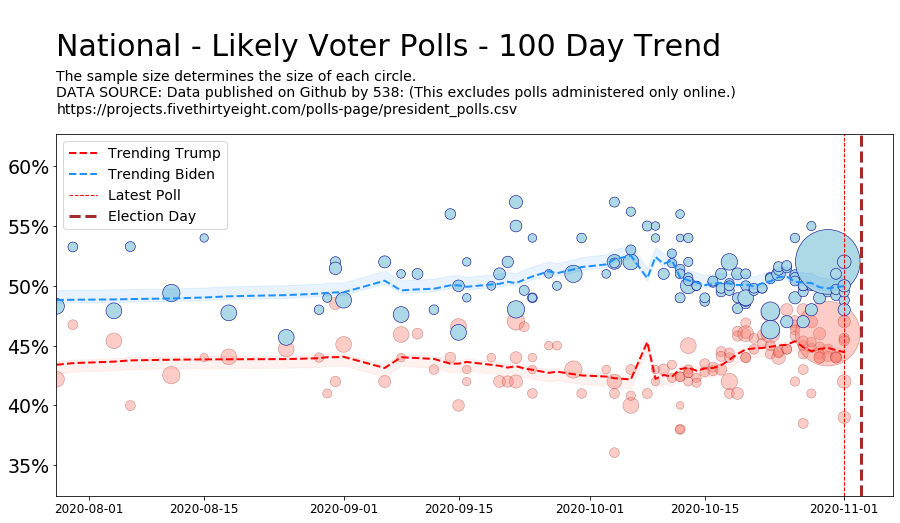

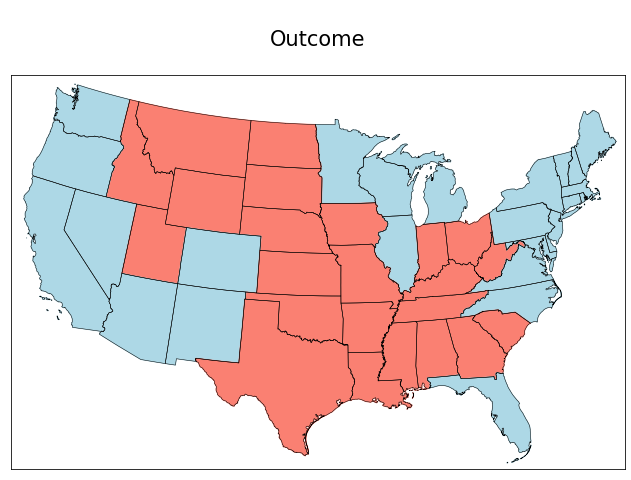

In [14]:
df = main(poll_location = 'National',
          poll_type = 'lv', 
          days_to_subtract = 100,
          smoothing_distance = 22, 
          plot_data = True,
          polling_bias = '',
          bias_amount = 0)

forecast_lv = display_forecast(states_list, 
                            poll_type = 'lv', 
                            polling_bias = 'None', 
                            bias_amount = 0, 
                            days_to_look_back = 250, 
                            smoothing_distance = 22, 
                            plot_states = False, 
                            election_map = True)

# Let's compare this to the actual results we have so far. 

Look at a list of states that have been won and by how much at 5:00 pm, 11/4/2020. 

In [15]:
results = [('Washington',61,36.9),('Oregon',57.5,40.2),('California',65.2,32.9),('Arizona',51.0,47.6),('Utah',38.0,58.5),
           ('Idaho',33.1,63.9),('Montana',40.7,56.8),('Wyoming',26.7,70.4),('North Dakota',31.9,65.5),('South Dakota',33.2,64.1),
          ('Nebraska',39.1, 58.8),('Colorado',55.5,42.0),('New Mexico',53.9,43,9),('Texas',46.3,52.3),('Oklahoma',32.3, 65.4),
          ('Kansas',41.1,56.7),('Minnesota',52.6,45.4), ('Iowa',45,53.2),('Illinois',55.1,43.1),('Missouri',41.3,56.9),
          ('Arkansas',34.6,62.6),('Louisiana',39.8, 58.5),('Mississippi',39.2, 59.4), ('Tennessee',37.4, 60.7),
          ('Kentucky',35.7, 62.6), ('Indiana', 39.8, 58.2),('Ohio',45.2, 53.4), ('West Virginia',29.6, 68.7),
          ('Alabama',36.4, 62.5), ('Florida', 47.9, 51.2), ('South Carolina', 43.1, 55.4), ('Virginia', 54.0, 44.5),
          ('Maryland', 62.6, 35.6), ('District of Columbia', 93.4, 5.2), ('Delaware', 58.8, 39.8), ('New Jersey', 60.7, 38.2),
          ('Connecticut', 57.2, 41.3), ('Rhode Island', 59.4, 39.2), ('Massachusetts', 65.7, 32.5), ('New Hampshire', 52.8, 45.6),
          ('Vermont', 66.4, 30.8), ('Michigan',49.9,48.6), ('Maine', 52.9, 44.2)]

Create a dataframe of the results and merge with the anticipated results and calculate the difference

In [16]:
current_states, current_biden, current_trump = [],[],[]

for result in results:
    current_states.append(result[0])
    current_biden.append(result[1])
    current_trump.append(result[2])
current = pd.DataFrame({'state':current_states,'current_biden':current_biden,'current_trump':current_trump})
current = current.merge(forecast_lv[['state','biden','trump']], how = 'inner', on = 'state').rename(columns = {'trump':'anticipated_trump', 'biden':'anticipated_biden'})

# calculate difference between the actual and predicted
current['diff_trump'] = current['current_trump'] - current['anticipated_trump']
current['diff_biden'] = current['current_biden'] - current['anticipated_biden']
current.head()

,state,current_biden,current_trump,anticipated_biden,anticipated_trump,diff_trump,diff_biden
0,Washington,61.0,36.9,61.89220,37.00000,-0.10000,-0.89220
1,Oregon,57.5,40.2,60.00000,39.00000,1.20000,-2.50000
2,California,65.2,32.9,62.02772,34.17725,-1.27725,3.17228
3,Arizona,51.0,47.6,48.82290,46.53448,1.06552,2.17710
4,Utah,38.0,58.5,43.38602,54.67670,3.82330,-5.38602


Calculate the mean differences and standard deviations

In [17]:
print('The average anticipated difference for Biden is: {} standard dev: {}'.format(current['diff_biden'].mean(), current['diff_biden'].std()))
print('The average anticipated difference for Trump is: {} standard def: {}'.format(current['diff_trump'].mean(), current['diff_trump'].std()))

The average anticipated difference for Biden is: -2.4921990697674423 standard dev: 2.590167324662006
The average anticipated difference for Trump is: 2.2915260465116276 standard def: 2.353463441802456


# It would appear that the local state-level polls underestimated Trump by 2.49%, and those same polls seemed to over-estimate Biden by 2.29%. That's 4.78% in Biden's favor. Let's adjust for that and look at the election outcome with that bias baked into state-level polls. (This is an estimate because it's not evently split. However, it's very close.) 

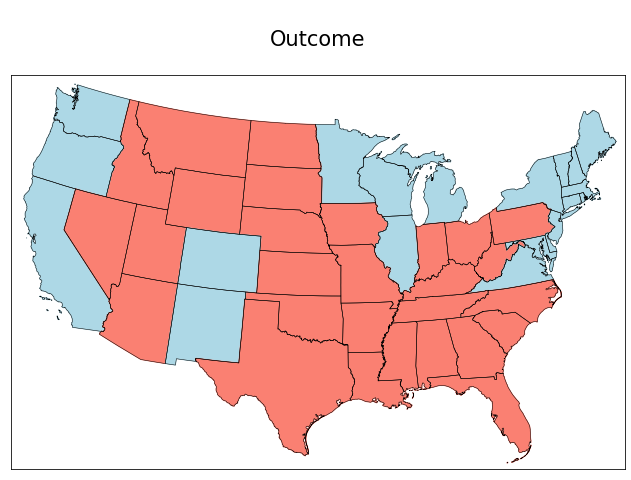

In [19]:
forecast_lv = display_forecast(states_list, 
                            poll_type = 'lv', 
                            polling_bias = 'biden', 
                            bias_amount = 4.78, 
                            days_to_look_back = 250, 
                            smoothing_distance = 22, 
                            plot_states = False, 
                            election_map = True)

It seems like the local state-level polls were biased in favor of Biden’s popular vote in the states by an average of 2.49%. At the same time, the state polls seem to be biased against Trump by an average of 2.29%  Could it be that the pollsters were weighing their samples incorrectly in favor of Biden or is it possible that the surge in participation threw off the likely voter models pollsters rely on? Here is the Jupyter-Notebook I wrote that reads the polling data for the 2020 Presidential election, sorts through it and plots the polling results – as well as the election outcome based on those state level polls. The final vote count is not in, and we won’t be sure until the last count is complete. 